<a href="https://colab.research.google.com/github/IslamiTP/Intro-to-LLM-Homework-2/blob/main/run_ollama_in_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Run Ollama in Colab

### Code to initialize llama using Unsloth was retrieved from

https://colab.research.google.com/drive/1T5-zKWM_5OD21QHwXHiV9ixTRR7k3iB9?usp=sharing#scrollTo=2eSvM9zX_2d3

In [109]:
%%capture
!pip install unsloth
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git@nightly git+https://github.com/unslothai/unsloth-zoo.git

In [110]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = False # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",      # Llama-3.1 2x faster
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-405B-bnb-4bit",    # 4bit for 405b!
    "unsloth/Mistral-Small-Instruct-2409",     # Mistral 22b 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3.5-mini-instruct",           # Phi-3.5 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/gemma-2-9b-bnb-4bit",
    "unsloth/gemma-2-27b-bnb-4bit",            # Gemma 2x faster!

    "unsloth/Llama-3.2-1B-bnb-4bit",           # NEW! Llama 3.2 models
    "unsloth/Llama-3.2-1B-Instruct-bnb-4bit",
    "unsloth/Llama-3.2-3B-bnb-4bit",
    "unsloth/Llama-3.2-3B-Instruct-bnb-4bit",

    "unsloth/Llama-3.3-70B-Instruct-bnb-4bit" # NEW! Llama 3.3 70B!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Llama-3.2-3B-Instruct", # or choose "unsloth/Llama-3.2-1B-Instruct"
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

==((====))==  Unsloth 2025.3.11: Fast Llama patching. Transformers: 4.48.3.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [111]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 1, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

In [112]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3.2",
)

def formatting_train_prompts(examples):
    convos = examples["conversations"]
    texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False) for convo in convos]
    return { "text" : texts, }

def tokenize_function(examples):
    return tokenizer(
        examples["text"],  # Use only text
        padding="max_length",
        truncation=True,
        max_length=2048,
        return_tensors="pt"
    )

from datasets import load_dataset

# Load the full dataset
full_dataset = load_dataset("mlabonne/FineTome-100k", split="train")

# Split the dataset into training and testing sets (e.g., 80% train, 20% test)
split_datasets = full_dataset.train_test_split(test_size=0.2, seed=42)

# Access the train and test splits
train_dataset = split_datasets['train']
test_dataset = split_datasets['test']

print(f"Train dataset: {train_dataset}")
print(f"Test dataset: {test_dataset}")

Train dataset: Dataset({
    features: ['conversations', 'source', 'score'],
    num_rows: 80000
})
Test dataset: Dataset({
    features: ['conversations', 'source', 'score'],
    num_rows: 20000
})


In [113]:
from unsloth.chat_templates import standardize_sharegpt
train_dataset = standardize_sharegpt(train_dataset)
train_dataset = train_dataset.map(formatting_train_prompts, batched = True,)
test_dataset = standardize_sharegpt(test_dataset)
test_dataset = test_dataset.map(formatting_train_prompts, batched=True)
tokenized_datasets = test_dataset.map(tokenize_function, batched=True)

In [116]:
# Before training inference outcome from continue fibonacci sequence question.

from unsloth.chat_templates import get_chat_template
import torch

tokenizer = get_chat_template(
    tokenizer,
    chat_template="llama-3.2",
)

messages = [
    {"role": "user", "content": "Continue the Fibonacci sequence: 1, 1, 2, 3, 5, 8,\n\n"},
]

inputs = tokenizer.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,  # Must add for generation
    return_tensors="pt",
).to("cuda")

# Use torch.no_grad() for inference without locking the model
with torch.no_grad():
    outputs = model.generate(
        input_ids=inputs,
        max_new_tokens=2048,
        use_cache=True,
        temperature=1.5,
        min_p=0.1
    )

output = tokenizer.batch_decode(outputs, skip_special_tokens=True)
print(output[0])

system

Cutting Knowledge Date: December 2023
Today Date: 26 July 2024

user

Continue the Fibonacci sequence: 1, 1, 2, 3, 5, 8,

assistant

The next numbers in the Fibonacci sequence are:

13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765, 10946, 17711, 28657, 46368, 75025, 121393, 196418, 317811, 514229, 832040, 1346269, 2178309, 3524578, 5702887, 9227465, 14930352, 24157817, 39088169, 63245986, 102334155, 165580141, 267914296, 433494437, 701408733, 1134903170...


# Question #1
#### Grabbing questions from different datasets for text summarization, question answering, text classification, role playing, and reasoning

In [125]:
# Fetching multiple datasets and loading them for inference

from datasets import load_dataset
import pandas as pd

# Define a function to format datasets
def format_dataset(dataset_name, dataset):
    formatted_data = []

    if dataset_name == "cnn_dailymail" or dataset_name == "xsum":
        # For summarization datasets, use the content as the article and the role as the summary
        for example in dataset["train"]:
            formatted_data.append({
                "content": example["article"],
                "role": example["highlights"] if dataset_name == "cnn_dailymail" else example["summary"]
            })

    elif dataset_name == "squad":
        print(dataset.column_names)
        # For SQuAD, we need to pair the context (content) with the question (role) and the answer
        for example in dataset["train"]:
            for qa in example["qas"]:
                formatted_data.append({
                    "content": example["context"],
                    "role": qa["question"]
                })

    elif dataset_name == "natural_questions":
        # For Natural Questions, use the question as role and the context as content
        for example in dataset["train"]:
            formatted_data.append({
                "content": example["document_text"],
                "role": example["question_text"]
            })

    elif dataset_name == "ag_news":
        # For text classification datasets, the content is the news article and the role is the label
        for example in dataset["train"]:
            formatted_data.append({
                "content": example["text"],
                "role": example["label"]
            })

    elif dataset_name == "imdb":
        # For sentiment analysis, the content is the review and the role is the sentiment (positive/negative)
        for example in dataset["train"]:
            formatted_data.append({
                "content": example["text"],
                "role": example["label"]
            })

    elif dataset_name == "daily_dialog":
        # For dialog datasets, we need to pair the dialogue (content) with the speaker role
        for example in dataset["train"]:
            for i, utt in enumerate(example["dialog"]):
                role = "user" if i % 2 == 0 else "agent"
                formatted_data.append({
                    "content": utt,
                    "role": role
                })

    elif dataset_name == "persona_chat":
        # For persona chat, content is the dialogue and role is the persona-based speaker
        for example in dataset["train"]:
            for i, utt in enumerate(example["dialog"]):
                role = "user" if i % 2 == 0 else "persona"
                formatted_data.append({
                    "content": utt,
                    "role": role
                })

    elif dataset_name == "piqa":
        # For PIQA, the content is the question and the role is the answer
        for example in dataset["train"]:
            formatted_data.append({
                "content": example["question"],
                "role": example["answerA"]  # You can choose answerA or answerB depending on your use case
            })

    elif dataset_name == "commonsense_qa":
        # For commonsense QA, the content is the question and the role is the answer
        for example in dataset["train"]:
            formatted_data.append({
                "content": example["question"],
                "role": example["answer"]
            })

    return formatted_data

# List of datasets to load
datasets = ["cnn_dailymail", "squad", "natural_questions", "ag_news",
            "imdb", "daily_dialog", "persona_chat", "piqa", "commonsense_qa"]

# Load and format all datasets
formatted_datasets = {}
for dataset_name in datasets:
    print(f"Loading and formatting {dataset_name}...")
    # Load the dataset
    dataset = load_dataset(dataset_name, '3.0.0') if dataset_name == "cnn_dailymail" else load_dataset(dataset_name)

    # Format the dataset
    formatted_data = format_dataset(dataset_name, dataset)

    # Store the formatted data in a dictionary
    formatted_datasets[dataset_name] = formatted_data

# Now, `formatted_datasets` contains all datasets in the desired format: {"content": "", "role": ""}
# Example usage:
# Print the first entry from the IMDB dataset
print(formatted_datasets["imdb"][0])

# You can also convert them into DataFrames for easier handling
for dataset_name, data in formatted_datasets.items():
    df = pd.DataFrame(data)
    print(f"First few entries of {dataset_name}:")
    print(df.head())

Loading and formatting cnn_dailymail...
Loading and formatting squad...
{'train': ['id', 'title', 'context', 'question', 'answers'], 'validation': ['id', 'title', 'context', 'question', 'answers']}


KeyError: 'qas'

# Question #2
#### Fine-tuning using LORA and SFTTrainer which is a special trainer designed to fine-tune models.

In [119]:
from trl import SFTTrainer
from transformers import TrainingArguments, DataCollatorForSeq2Seq
from unsloth import is_bfloat16_supported

max_seq_length = 2048
dtype = None  # Auto detection, change if needed
load_in_4bit = False  # Set to True if using 4bit quantization

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    dataset_text_field = "text",  # Keep this as "text" since that's what formatting_func returns
    max_seq_length = max_seq_length,
    data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer),
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        num_train_epochs = 1, # Set this for 1 full training run.
        learning_rate = 9e-4,
        max_steps=60,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    ),
)

Unsloth: We found double BOS tokens - we shall remove one automatically.


{'eval_loss': 1.2571914196014404, 'eval_model_preparation_time': 0.007, 'eval_runtime': 48.7897, 'eval_samples_per_second': 4.099, 'eval_steps_per_second': 0.512}
['conversations', 'source', 'score', 'text']


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 80,000 | Num Epochs = 1 | Total steps = 60
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 1,519,616/3,214,269,440 (0.05% trained)


Step,Training Loss
1,0.951800
2,1.018900
3,0.985800
4,0.987500
5,0.867400
6,0.879400
7,0.659000
8,0.668700
9,0.725300
10,0.808200


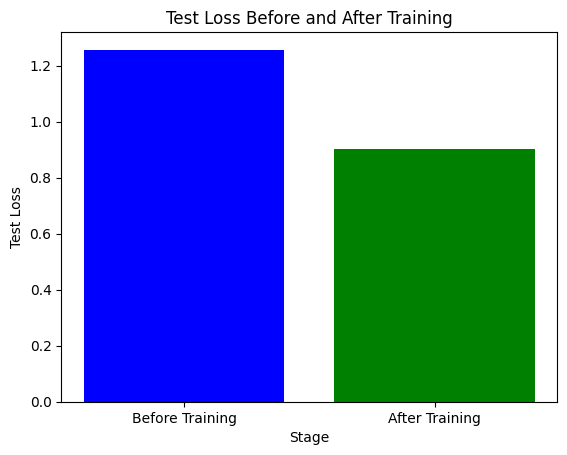

In [120]:
import matplotlib.pyplot as plt

# Assuming you already have the model, test_dataset, and trainer set up

# Calculate the test loss before training
trainer.model.eval()  # Set the model to evaluation mode

before_training_results = trainer.evaluate(tokenized_datasets.select(range(200)))
print(before_training_results)
before_training_loss = before_training_results["eval_loss"]

print(train_dataset.column_names)
# Train the model

trainer.train()

# Calculate the test loss after training
trainer.model.eval()  # Set the model back to evaluation mode
after_training_results = trainer.evaluate(tokenized_datasets.select(range(200)))
after_training_loss = after_training_results["eval_loss"]

# Prepare the data for the bar plot
losses = [before_training_loss, after_training_loss]
labels = ['Before Training', 'After Training']

# Create the bar plot
plt.bar(labels, losses, color=['blue', 'green'])
plt.xlabel('Stage')
plt.ylabel('Test Loss')
plt.title('Test Loss Before and After Training')
plt.show()

In [ ]:
# After training inference outcome from continue fibonacci sequence question.

from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3.2",
)
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

messages = [
    {"role": "user", "content": "Continue the fibonnaci sequence: 1, 1, 2, 3, 5, 8,\n\n"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

outputs = model.generate(input_ids = inputs, max_new_tokens = max_seq_length, use_cache = True,
                         temperature = 1.5, min_p = 0.1)

output = tokenizer.batch_decode(outputs, skip_special_tokens=True)

print(output[0])